<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Monthly_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
url='https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'
retail = pd.read_csv(url, encoding = 'unicode_escape')
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])
retail['InvoiceYM']=retail['InvoiceDate'].apply(lambda x: x.strftime('%Y%m'))
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [0]:
retail['Revenue'] = retail['UnitPrice'] * retail['Quantity']
minyearmonth = retail.groupby(['CustomerID'])['InvoiceDate'].min().apply(lambda x: x.strftime('%Y%m')).to_frame('MinYearMonth')
retail=retail.join(minyearmonth, on='CustomerID')
retail['CustomerType'] = np.where(retail['InvoiceYM'] == retail['MinYearMonth'], 'New', 'Exist')

In [13]:
rev = retail.groupby(['InvoiceYM', 'CustomerType'])['Revenue'].sum().unstack()
rev['Total'] = rev.sum(axis=1)
rev

CustomerType,Exist,New,Total
InvoiceYM,,,
201012,194353.000,554604.020,748957.020
201101,356542.400,203457.860,560000.260
201102,348541.270,149521.380,498062.650
201103,493337.000,189930.080,683267.080
201104,373442.870,119764.251,493207.121
201105,607474.770,115858.740,723333.510
201106,598596.610,92526.510,691123.120
201107,615417.240,65882.871,681300.111
201108,605022.280,77658.230,682680.510


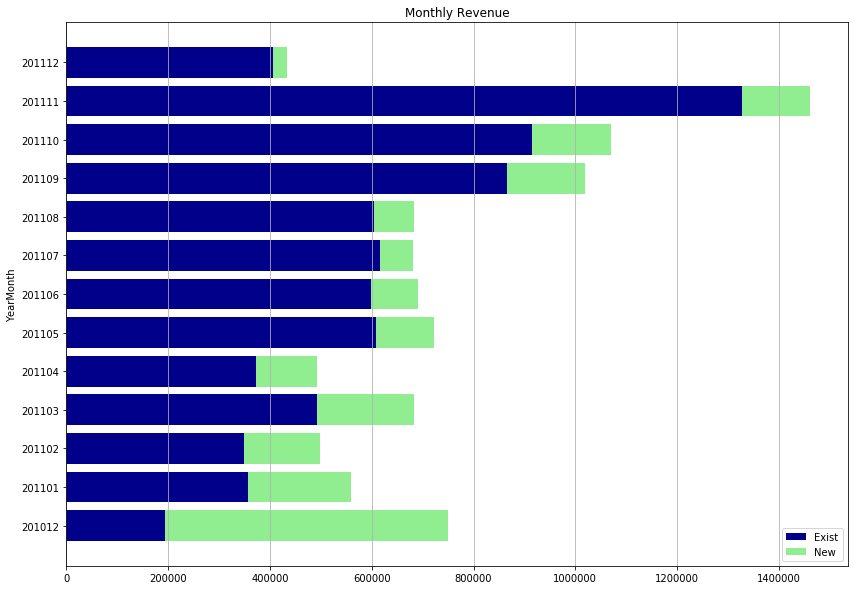

In [29]:
plt.figure(figsize=(14, 10))
plt.barh(rev.index, rev['Exist'], color='darkblue', label='Exist')
plt.barh(rev.index, rev['New'], color='lightgreen', left=rev['Exist'], label='New')
plt.title('Monthly Revenue')
plt.ylabel('YearMonth')
plt.legend(loc='lower right')
plt.grid(axis='x')